# Artificial Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'png'
from plotly.subplots import make_subplots

from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### Artificial Neural Network

> #### ANNs
> - $\hat{y}=\sigma(x_0 w_0 + \sum_{i=1}^m x_iw_i)$
> - $\hat{y}=\sigma(\textbf{x}^\text{T}\textbf{w}+w_0)$
> - $\hat{y}=\sigma(\textbf{x}^\text{T}\textbf{w})$
>   - $\sigma$: activation function
>   - $\textbf{x}$: input vector
>   - $\textbf{w}$: weights
>   - $w$: bias (intercept)

> #### Loss Function
> - $\mathcal{L}_\text{MSE}= \dfrac{1}{2}(\hat{y}-y)^2$
> - $\mathcal{L}_\text{Cross-Entropy}= -(y\log (\hat{y}) + (1-y)\log (1-\hat{y}))$

> #### Cost Function
> - $\mathcal{J} = \dfrac{1}{n}\sum_{i=1}^n \mathcal{L}(\hat{y}_i , y_i)$

> #### Backpropagation
> - $\mathbf{w} \leftarrow \mathbf{w} - \eta \partial \mathcal{L}$
> - $\dfrac{\partial \mathcal{L} (\hat{y},y)}{\partial \textbf{w}} = \dfrac{\partial \mathcal{L} (\sigma(\textbf{x}^\text{T}\textbf{w}),y)}{\partial \textbf{w}}$
>   - $\eta$: learning rate 
>   - $\partial \mathcal{L}$: derivative of loss

___
### Simple Regression

- $y_i = \beta_0 + \beta_1x_1 + \epsilon_1$

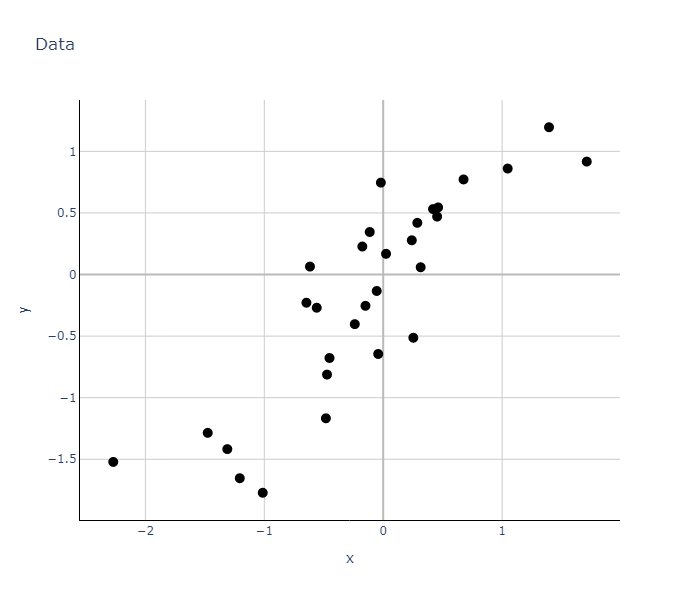

In [2]:
N = 30
x = torch.randn(N, 1)
y = x + torch.randn(N, 1)/2

main_fig = go.Figure()
main_fig.add_trace(go.Scatter(
    x=x.squeeze(), y=y.squeeze(), marker=dict(color='black', size=10),
    mode='markers', name='data'
))
plotly_main_layout(main_fig, title='Data')

In [3]:
ANNreg = nn.Sequential(
    nn.Linear(1,1),  # linear model
                     # in_features=1,out_features=1, bias=True
    # nn.ReLU(),       # Activation function (not needed)
    nn.Linear(1,1)   # Output layer
)

learningRate = 0.05
lossfun = nn.MSELoss()
optimizer = torch.optim.SGD(ANNreg.parameters(), lr=learningRate)

numepochs = 500
losses = torch.zeros(numepochs)

for epoch_i in range(numepochs):
    yHat = ANNreg(x)         # Forward prop

    loss = lossfun(yHat, y)  # Stores loss
    losses[epoch_i] = loss   

    optimizer.zero_grad()    # Backpropagation
    loss.backward()
    optimizer.step()         

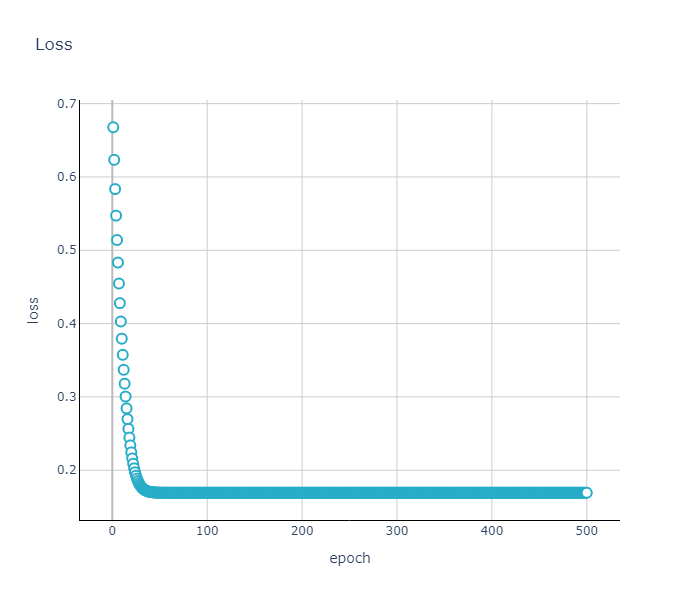

In [4]:
predictions = ANNreg(x)

testloss = (predictions-y).pow(2).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
))
plotly_main_layout(fig, x='epoch', y='loss', title='Loss')

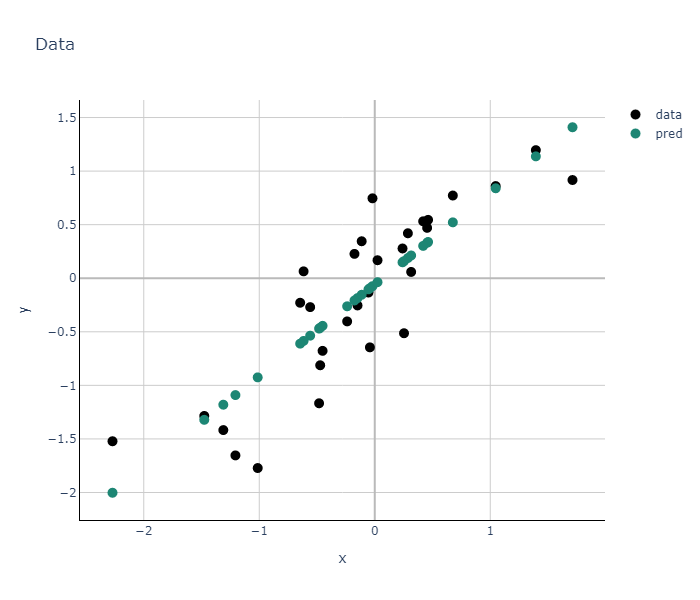

In [5]:
main_fig.add_trace(go.Scatter(
    x=x.squeeze(), y=predictions.squeeze().detach(), mode='markers',
    marker=dict(color='#1d8674', size=10), name='pred'
))

___
### Manipulate Regression Slopes

In [6]:
def buildAndTrainTheModel(x,y):
    ANNreg = nn.Sequential(
        nn.Linear(1,1),  # linear model
        nn.Linear(1,1)   # Output layer
    )

    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(ANNreg.parameters(), lr=0.05)

    numepochs = 500
    losses = torch.zeros(numepochs)

    for epoch_i in range(numepochs):
        yHat = ANNreg(x)         # Forward prop

        loss = lossfun(yHat, y)  # Stores loss
        losses[epoch_i] = loss   

        optimizer.zero_grad()    # Backpropagation
        loss.backward()
        optimizer.step()      

    predictions = ANNreg(x)

    return predictions.squeeze(), losses


def createTheData(m):
    N = 50
    x = torch.randn(N,1)
    y = m*x + torch.randn(N,1)/2
    return x, y

In [7]:
slopes = np.linspace(-2,2,21)

numExps = 50

results = np.zeros((len(slopes),numExps,2))

for slopei in range(len(slopes)):

  for N in range(numExps):

    # create a dataset and run the model
    x,y = createTheData(slopes[slopei])
    yHat,losses = buildAndTrainTheModel(x,y)
    yHat = yHat.detach()

    # store the final loss and performance
    results[slopei,N,0] = losses[-1]
    results[slopei,N,1] = np.corrcoef(y.T,yHat.T)[0,1]


# correlation can be 0 if the model didn't do well. Set nan's->0
results[np.isnan(results)] = 0

C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_20316\366245340.py:18: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4416.)



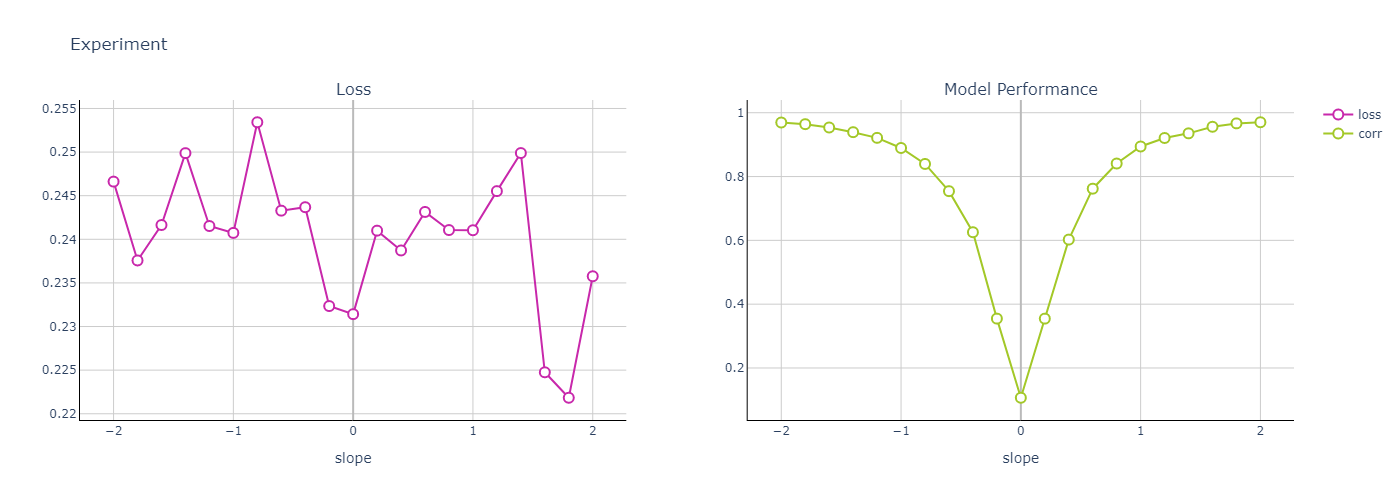

In [8]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Loss', 'Model Performance'])

fig.add_trace(go.Scatter(
    x=slopes, y=np.mean(results[:,:,0], axis=1),
    mode='markers+lines', marker=dict(color='white', size=10, line=dict(color='#c828ab', width=2)),
    line=dict(color='#c828ab'), name='loss'
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=slopes, y=np.mean(results[:,:,1], axis=1),
    mode='markers+lines', marker=dict(color='white', size=10, line=dict(color='#a3c828', width=2)),
    line=dict(color='#a3c828'), name='corr'
), row=1, col=2)

plotly_main_subplot_layout(fig, title='Experiment', x='slope')

When the slope is close to 0, the models performance decreases since x is less informative relative to y.

___
### Binary Classification

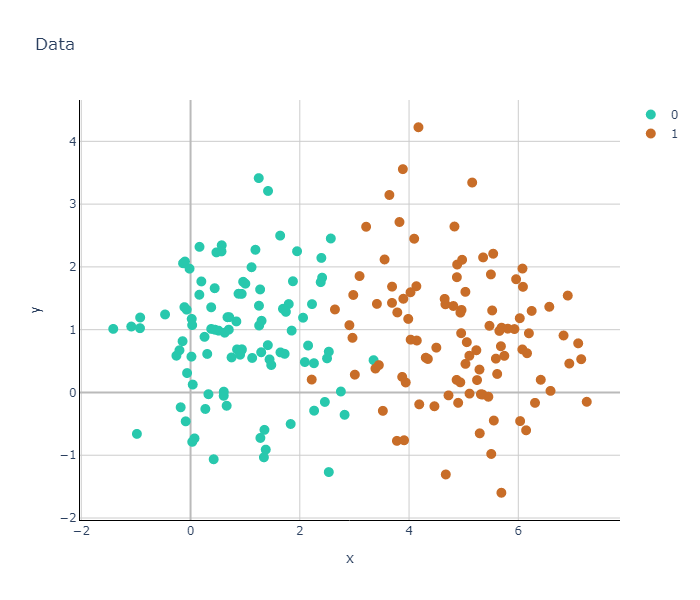

In [9]:
nPerClust = 100
blur = 1

A = [1, 1]
B = [5, 1]

# generate data
a = [A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

main_fig = go.Figure()
main_fig.add_trace(go.Scatter(
    x=data[np.where(labels==0)[0],0],
    y=data[np.where(labels==0)[0],1], name='0',
    mode='markers', marker=dict(color='#28c8ad', size=10)
))
main_fig.add_trace(go.Scatter(
    x=data[np.where(labels==1)[0],0],
    y=data[np.where(labels==1)[0],1], name='1',
    mode='markers', marker=dict(color='#c86d28', size=10)
))
plotly_main_layout(main_fig, title='Data')

In [10]:
ANNclassify = nn.Sequential(
    nn.Linear(2,1), # Input layer
    nn.ReLU(),      # Activation layer
    nn.Linear(1,1), # Output layer
    nn.Sigmoid(),   # Output activation layer
)

learningRate = 0.01
lossfun = nn.BCELoss()
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  yHat = ANNclassify(data)    # forward

  loss = lossfun(yHat,labels) # compute loss
  losses[epochi] = loss         

  optimizer.zero_grad()       # backpropagation
  loss.backward()
  optimizer.step()

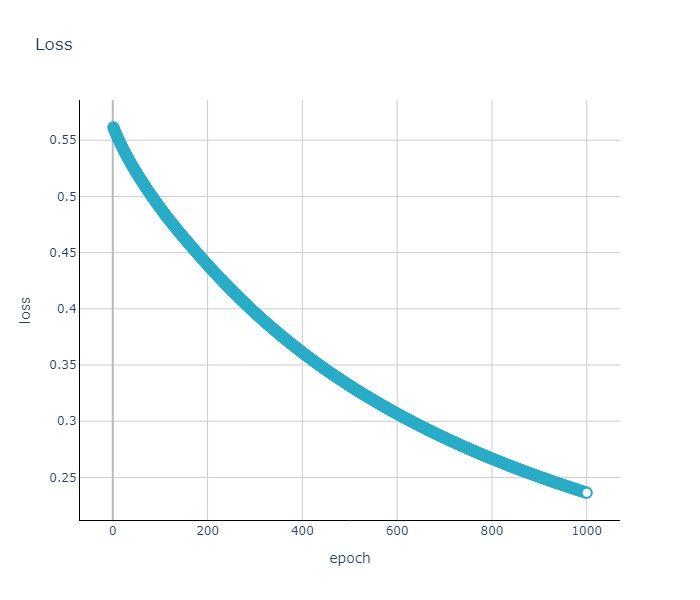

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
))
plotly_main_layout(fig, x='epoch', y='loss', title='Loss')

In [12]:
predictions = ANNclassify(data)
predlabels = predictions > 0.5

misclassified = np.where(predlabels != labels)[0]

totalacc = 100-100*len(misclassified)/(2*nPerClust)
print('Final accuracy: %g%%' %totalacc)

Final accuracy: 95%


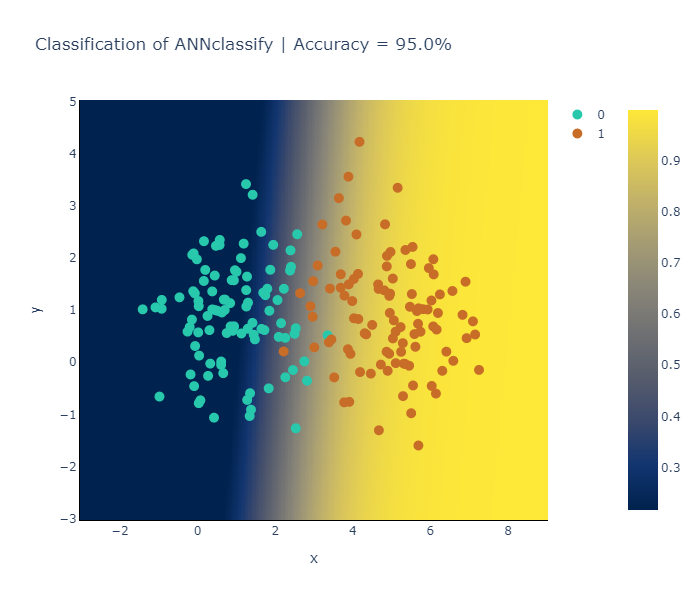

In [13]:
x = np.linspace(-3, 9, 200)
y = np.linspace(-3, 5, 150)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    inputs = torch.tensor(grid, dtype=torch.float32)
    outputs = ANNclassify(inputs)
    predictions = (outputs).numpy().reshape(xx.shape)

fig = go.Figure(data=go.Heatmap(
    z=predictions, x=x, y=y,
    colorscale='cividis',
    colorbar=dict(title='Class'),
    showscale=True
))

fig.add_traces(main_fig['data'])
fig = plotly_main_layout(fig, title=f'Classification of ANNclassify | Accuracy = {totalacc}%')
fig['data'][0].colorbar = dict(x=1.15)
fig

___
### Multilayer ANN

- $\ell_1 = \sigma(\textbf{x}_0^\text{T}\textbf{w}_1)$
- $\ell_2 = \sigma(\ell_1^\text{T}\textbf{w}_2) \rightarrow \ell_2 = \sigma(\sigma(\textbf{x}_0^\text{T}\textbf{w}_1)^\text{T}\textbf{w}_2)$
    - $\ell$: layer

In [14]:
def createANNmodel(learningRate):
    ANNclassify = nn.Sequential(
        nn.Linear(2,16),
        nn.Linear(16,1),
        nn.Linear(1,1),
        nn.Sigmoid(),
    )

    lossfun = nn.BCELoss()
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    return ANNclassify, lossfun, optimizer


def trainTheModel(ANNmodel):
  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final forward pass
  predictions = ANNmodel(data)
    
  # compute the predictions and report accuracy
  totalacc = 100*torch.mean(((predictions>.5) == labels).float())
  
  return losses, predictions, totalacc

Final accuracy: 97.5%


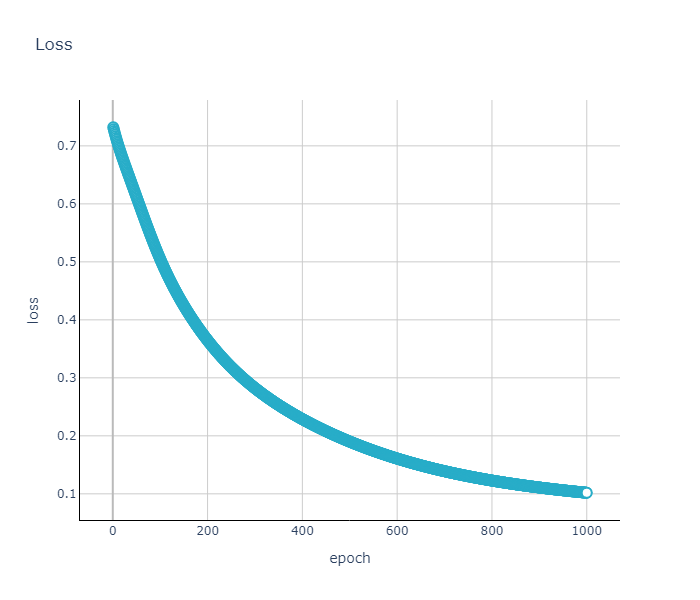

In [15]:
# create everything
ANNclassify, lossfun, optimizer = createANNmodel(0.01)
losses, predictions, totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)

# show the losses
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
))
plotly_main_layout(fig, x='epoch', y='loss', title='Loss')

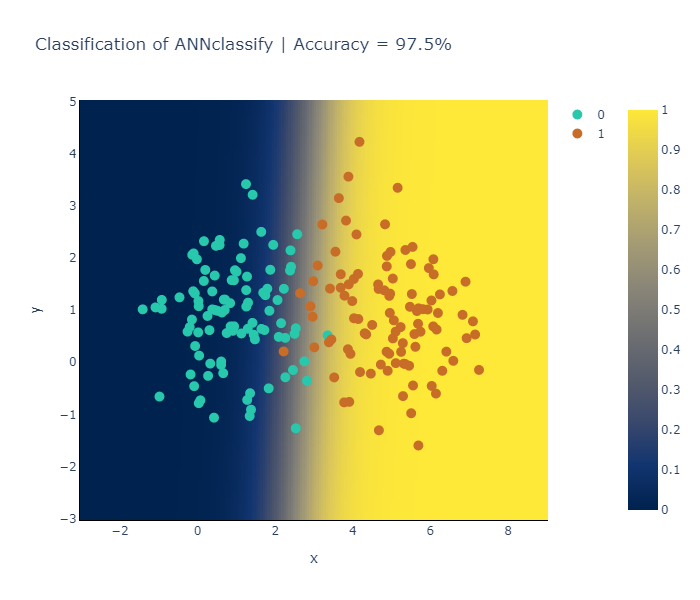

In [16]:
x = np.linspace(-3, 9, 200)
y = np.linspace(-3, 5, 150)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    inputs = torch.tensor(grid, dtype=torch.float32)
    outputs = ANNclassify(inputs)
    predictions = (outputs).numpy().reshape(xx.shape)

fig = go.Figure(data=go.Heatmap(
    z=predictions, x=x, y=y,
    colorscale='cividis',
    colorbar=dict(title='Class'),
    showscale=True
))

fig.add_traces(main_fig['data'])
fig = plotly_main_layout(fig, title=f'Classification of ANNclassify | Accuracy = {totalacc}%')
fig['data'][0].colorbar = dict(x=1.15)
fig

___
### Multi-Output Classification

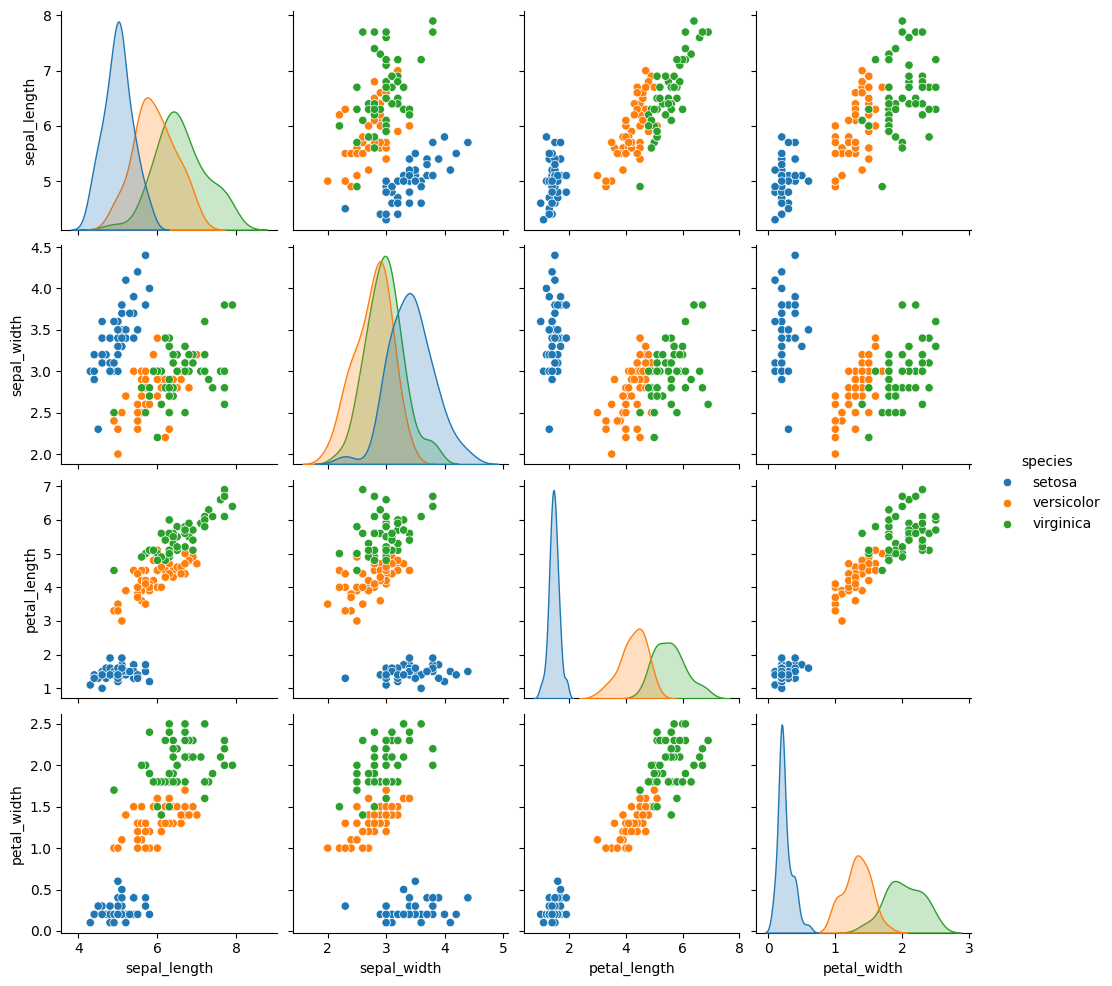

In [17]:
iris = sns.load_dataset('iris')
sns.pairplot(iris, hue='species');

data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris['species'] == 'versicolor'] = 1
labels[iris['species'] == 'virginica'] = 2

In [18]:
def fitANNmodel(learningRate):
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )

    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=learningRate)

    return ANNiris, lossfun, optimizer

def trainModel(ANNmodel, numepochs=1000):
    numepochs = numepochs

    losses = torch.zeros(numepochs)
    ongoingAcc = []
    for epochi in range(numepochs):
        
        yHat = ANNmodel(data)

        loss = lossfun(yHat, labels)
        losses[epochi] = loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        matches = torch.argmax(yHat, axis=1) == labels
        matchesNumeric = matches.float()
        accuracyPct = 100*torch.mean(matchesNumeric)
        ongoingAcc.append(accuracyPct)

    predictions = ANNmodel(data)

    predlabels = torch.argmax(predictions, axis=1)
    totalacc = 100*torch.mean((predlabels == labels).float())

    return losses, predictions, totalacc, ongoingAcc, yHat

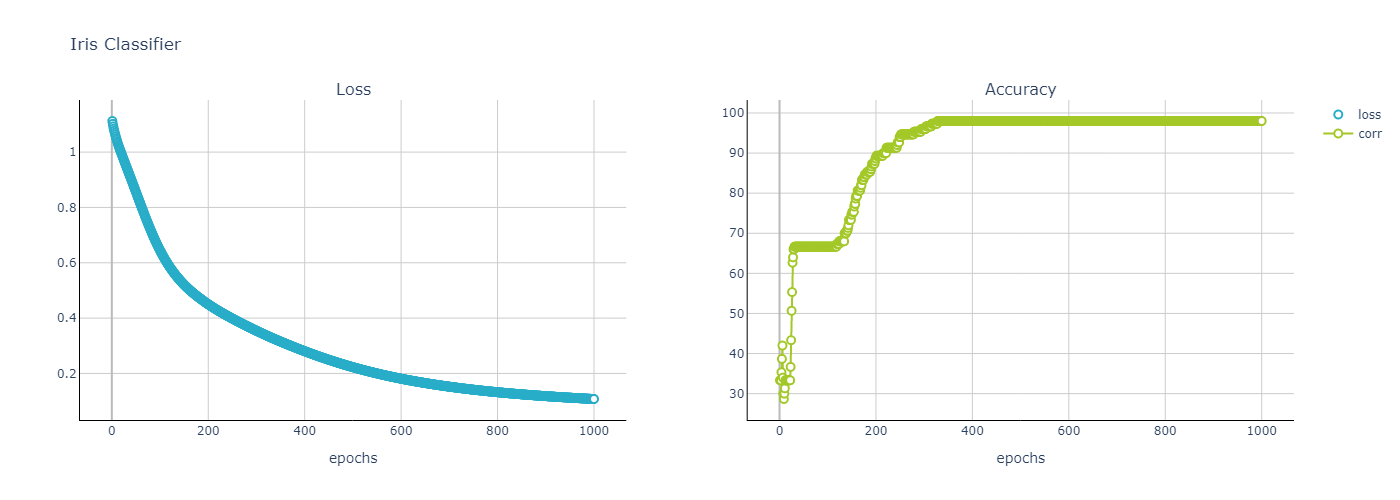

In [30]:
ANNclassify, lossfun, optimizer = fitANNmodel(learningRate=0.01)
numepochs = 1000
losses, predictions, totalacc, ongoingAcc, yHat = trainModel(ANNclassify, numepochs)

fig = make_subplots(rows=1, cols=2, subplot_titles=['Loss', 'Accuracy'])

fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=8)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=ongoingAcc,
    mode='markers+lines', marker=dict(color='white', size=8, line=dict(color='#a3c828', width=2)),
    line=dict(color='#a3c828'), name='corr'
), row=1, col=2)

plotly_main_subplot_layout(fig, title='Iris Classifier', x='epochs')

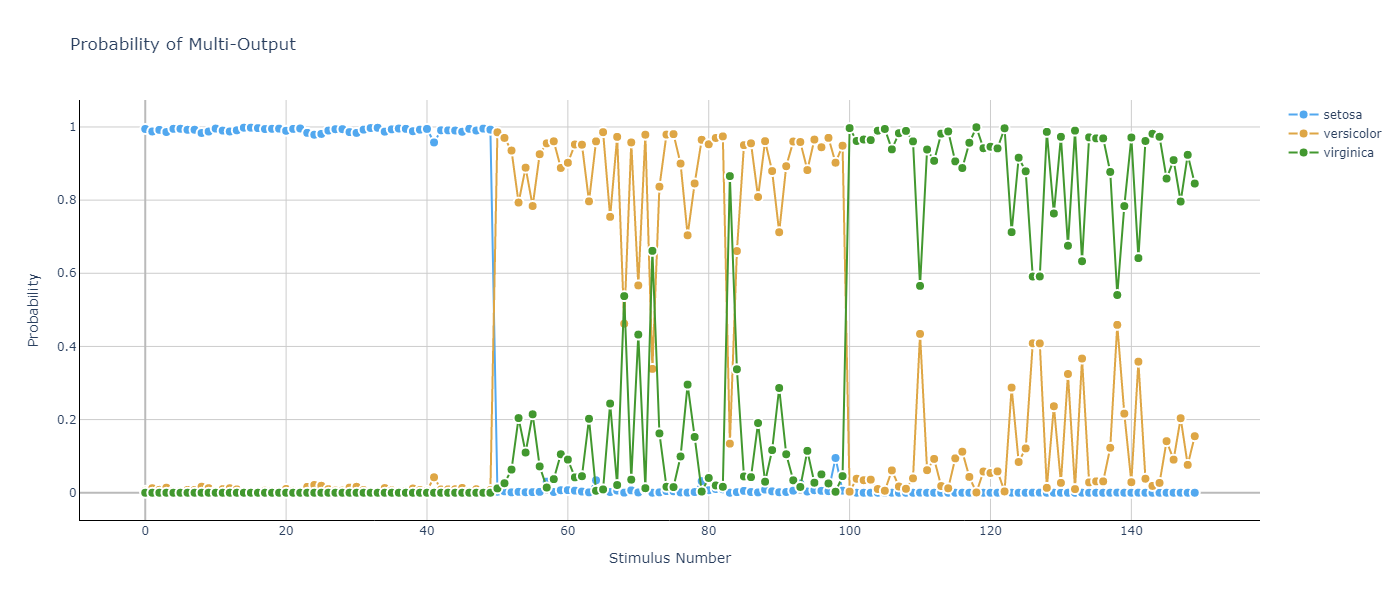

In [33]:
softmax = nn.Softmax(1)
fig_df = pd.DataFrame(softmax(yHat.detach()), columns=['setosa', 'versicolor', 'virginica'])

fig =go.Figure()
fig.add_trace(go.Scatter(
    x=fig_df.index, y=fig_df['setosa'], mode='markers+lines',
    name='setosa', marker=dict(color='#52a8ef', size=10, line=dict(color='white', width=2))
))
fig.add_trace(go.Scatter(
    x=fig_df.index, y=fig_df['versicolor'], mode='markers+lines',
    name='versicolor', marker=dict(color='#dea645', size=10, line=dict(color='white', width=2))
))
fig.add_trace(go.Scatter(
    x=fig_df.index, y=fig_df['virginica'], mode='markers+lines',
    name='virginica', marker=dict(color='#42982f', size=10, line=dict(color='white', width=2))
))
plotly_main_layout(fig, title='Probability of Multi-Output', x='Stimulus Number', y='Probability', width=1400)

___
### Sequential vs Class

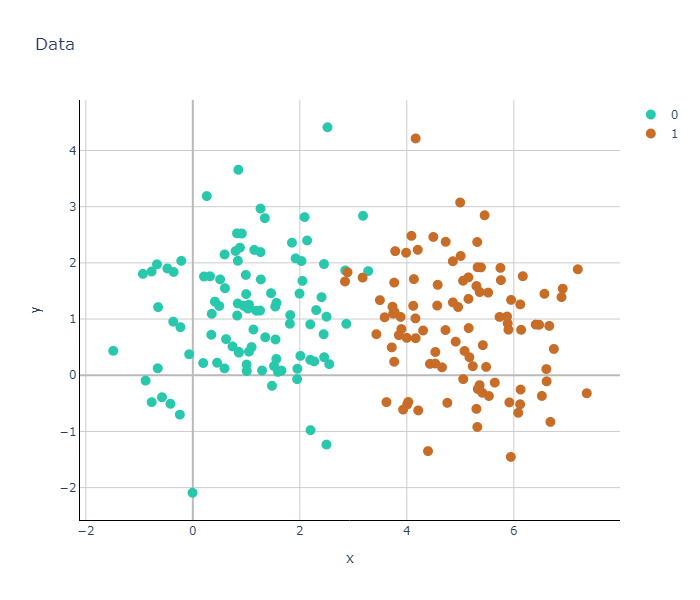

In [46]:
nPerClust = 100
blur = 1

A = [  1, 1 ]
B = [  5, 1 ]

a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
data_np = np.hstack((a,b)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

main_fig = go.Figure()
main_fig.add_trace(go.Scatter(
    x=data[np.where(labels==0)[0],0],
    y=data[np.where(labels==0)[0],1], name='0',
    mode='markers', marker=dict(color='#28c8ad', size=10)
))
main_fig.add_trace(go.Scatter(
    x=data[np.where(labels==1)[0],0],
    y=data[np.where(labels==1)[0],1], name='1',
    mode='markers', marker=dict(color='#c86d28', size=10)
))
plotly_main_layout(main_fig, title='Data')

In [56]:
class ClassANN(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2,1)
        self.output = nn.Linear(1,1)


    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
ANNclassify = ClassANN()
learningRate = 0.01
lossfun = nn.BCELoss()
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

numepochs = 10000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  yHat = ANNclassify(data)    # forward

  loss = lossfun(yHat,labels) # compute loss
  losses[epochi] = loss         

  optimizer.zero_grad()       # backpropagation
  loss.backward()
  optimizer.step()

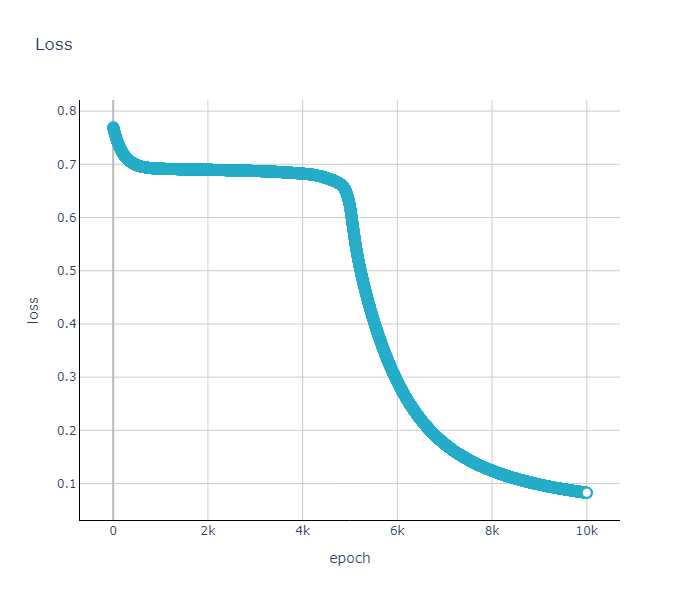

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
))
plotly_main_layout(fig, x='epoch', y='loss', title='Loss')

Final accuracy: 98.5%


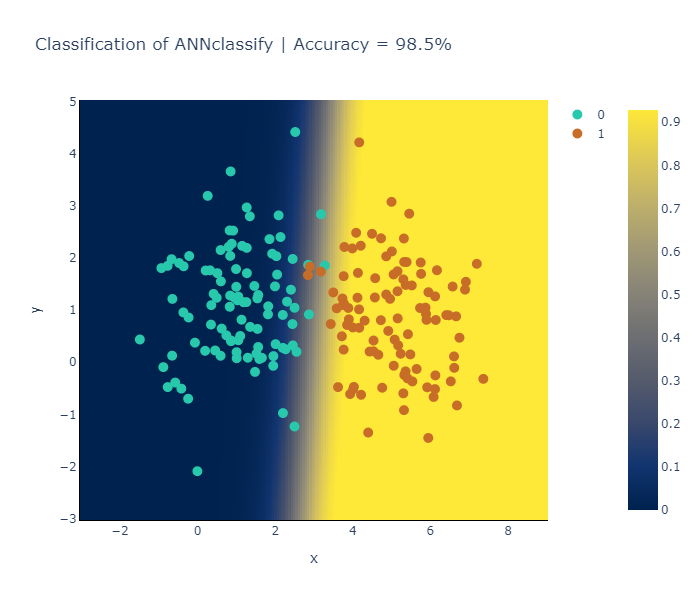

In [58]:
predictions = ANNclassify(data)
predlabels = predictions > 0.5

misclassified = np.where(predlabels != labels)[0]

totalacc = 100-100*len(misclassified)/(2*nPerClust)
print('Final accuracy: %g%%' %totalacc)

x = np.linspace(-3, 9, 200)
y = np.linspace(-3, 5, 150)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    inputs = torch.tensor(grid, dtype=torch.float32)
    outputs = ANNclassify(inputs)
    predictions = (outputs).numpy().reshape(xx.shape)

fig = go.Figure(data=go.Heatmap(
    z=predictions, x=x, y=y,
    colorscale='cividis',
    colorbar=dict(title='Class'),
    showscale=True
))

fig.add_traces(main_fig['data'])
fig = plotly_main_layout(fig, title=f'Classification of ANNclassify | Accuracy = {totalacc}%')
fig['data'][0].colorbar = dict(x=1.15)
fig

___
### Depth vs Breadth

In [59]:
widenet = nn.Sequential(
    nn.Linear(2,4),
    nn.Linear(4,3),
)

deepnet = nn.Sequential(
    nn.Linear(2,2),
    nn.Linear(2,2),
    nn.Linear(2,3),
)

for param in widenet.named_parameters():
    print(param, '\n')

numNodesInWide = 0
for param in widenet.named_parameters():
    if 'bias' in param[0]:
        numNodesInWide += len(param[1])

print('Number of nodes =', numNodesInWide)

nparams = 0
for param in widenet.parameters():
    if param.requires_grad:
        nparams += param.numel()
print('Number of parameters =', nparams)

('0.weight', Parameter containing:
tensor([[ 0.0811,  0.1094],
        [-0.3357,  0.4678],
        [ 0.0421, -0.6048],
        [-0.3006, -0.5234]], requires_grad=True)) 

('0.bias', Parameter containing:
tensor([ 0.5771, -0.1688, -0.3110, -0.3395], requires_grad=True)) 

('1.weight', Parameter containing:
tensor([[-0.4103,  0.1172, -0.4095,  0.0172],
        [ 0.0262, -0.3198, -0.0695,  0.3112],
        [-0.4972,  0.4659, -0.3560,  0.4034]], requires_grad=True)) 

('1.bias', Parameter containing:
tensor([-0.4900, -0.1794,  0.1823], requires_grad=True)) 

Number of nodes = 7
Number of parameters = 27


In [72]:
class ANNiris(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

        self.layers['input'] = nn.Linear(4,nUnits)

        for i in range(nLayers):
            self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

        self.layers['output'] = nn.Linear(nUnits, 3)

    
    def forward(self, x):
        x = self.layers['input'](x)
        for i in range(self.nLayers):
            x = F.relu(
                self.layers[f'hidden{i}'](x)
            )
        x = self.layers['output'](x)
        return x

In [73]:
nUnitsPerLayer = 12
nLayers = 4
net = ANNiris(nUnitsPerLayer, nLayers)
display(net)

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [74]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris['species'] == 'versicolor'] = 1
labels[iris['species'] == 'virginica'] = 2

In [75]:
def trainTheModel(theModel):
  # define the loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(theModel.parameters(),lr=.01)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = theModel(data)

    # compute loss
    loss = lossfun(yHat,labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final forward pass to get accuracy
  predictions = theModel(data)
  predlabels = torch.argmax(predictions,axis=1)
  acc = 100*torch.mean((predlabels == labels).float())

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

  return acc, nParams
     

numepochs = 2500
acc = trainTheModel(net)
acc

(tensor(96.6667), 723)

In [86]:
# define the model parameters
numlayers = range(1,6)         # number of hidden layers
numunits  = np.arange(4,101,3) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((len(numunits),len(numlayers)))
totalparams = np.zeros((len(numunits),len(numlayers)))

# number of training epochs
numepochs = 500

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create a fresh model instance
    net = ANNiris(numunits[unitidx],numlayers[layeridx])

    # run the model and store the results
    acc,nParams = trainTheModel(net)
    accuracies[unitidx,layeridx] = acc

    # store the total number of parameters in the model
    totalparams[unitidx,layeridx] = nParams

fig_df = pd.DataFrame(accuracies, columns=['1','2','3','4','5'])

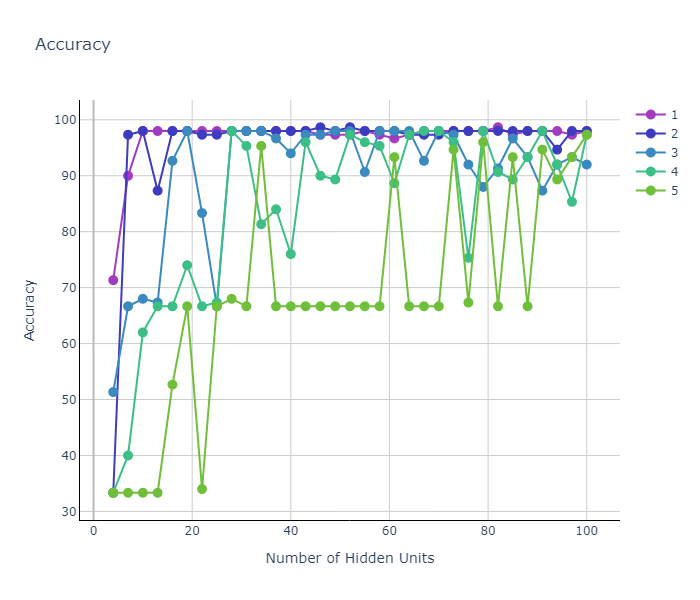

In [87]:
fig = go.Figure()
for col, color in zip(fig_df.columns, ['#a23bbf','#3d3bbf','#3b8abf','#3bbf86','#70bf3b']):
  fig.add_trace(go.Scatter(
      x=numunits, y=fig_df[col], marker=dict(color=color, size=10),
      mode='markers+lines', name=col,
  ))
plotly_main_layout(fig, title='Accuracy', x='Number of Hidden Units', y='Accuracy')
fig.show()

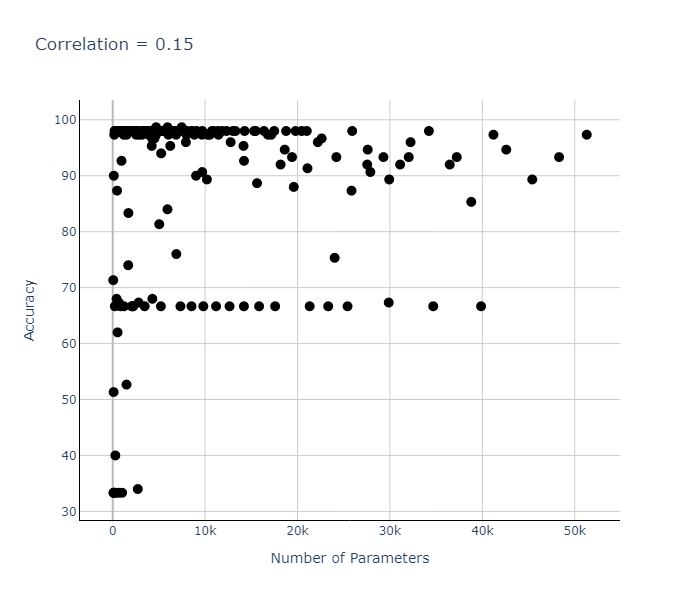

In [91]:
# vectorize for convenience
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, y=y, mode='markers', marker=dict(color='black', size=10)
))
plotly_main_layout(fig, title=f'Correlation = {r:.2f}', x='Number of Parameters', y='Accuracy')